In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

this is a test. I want to take an image and do automatic thresholding.

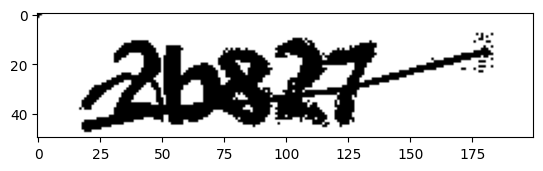

In [12]:
# images are in samples directory

img1 = cv2.imread('../samples/2b827.png', cv2.IMREAD_GRAYSCALE)

img1_thr = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

plt.imshow(img1_thr, cmap='gray')

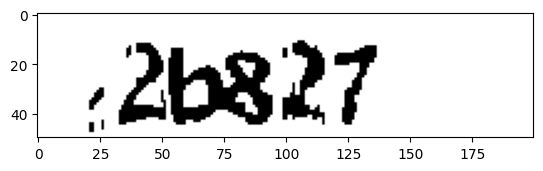

In [25]:
close_img1 = cv2.morphologyEx(img1_thr, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

close_img1 = cv2.dilate(close_img1, np.ones((2,2), np.uint8), iterations = 1)

plt.imshow(close_img1, cmap='gray')

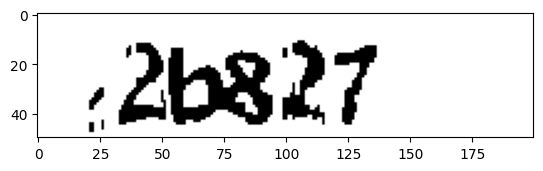

In [26]:
gauss_img1 = cv2.GaussianBlur(close_img1, (1,1), 0)

plt.imshow(close_img1, cmap='gray')